In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/iris")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'iris' dataset.
Path to dataset files: /kaggle/input/iris


In [2]:
!pip install scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Загрузка и раздение данных

In [14]:
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print(f"Размерность данных: {X.shape}")
print(f"Признаки: {feature_names}")
print(f"Классы: {target_names}")

# Разделение данных на test и train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nРазделение данных:")
print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")


Размерность данных: (150, 4)
Признаки: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Классы: ['setosa' 'versicolor' 'virginica']

Разделение данных:
Обучающая выборка: 120 записей
Тестовая выборка: 30 записей


# Создание моделей + стандартизация

In [15]:
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42))]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=42))]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42))])
}

**Оценка с помощью кросс-валидации**

In [16]:
cv_scores = {}
for name, model in models.items():
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
  cv_scores[name] = scores
  print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Logistic Regression: 0.9583 (+/- 0.0527)
SVM: 0.9667 (+/- 0.0624)
Random Forest: 0.9500 (+/- 0.0333)


**Подбор гиперпараметров**

In [17]:
param_grids = {
    'Logistic Regression': {
        'model__C': [0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'lbfgs']
    },
    'SVM': {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto', 0.1, 1],
        'model__kernel': ['linear', 'rbf']
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 5, 10]
    }
}

best_models = {}
best_scores = {}

for name in models.keys():
  print(f"\nПодбор параметров для {name}...")
  grid_search = GridSearchCV(
      models[name],
      param_grids[name],
      cv=5,
      scoring='accuracy',
      n_jobs=-1)
  grid_search.fit(X_train, y_train)

  best_models[name] = grid_search.best_estimator_
  best_scores[name] = grid_search.best_score_

  print(f"Лучшие параметры: {grid_search.best_params_}")
  print(f"Лучшая точность: {grid_search.best_score_:.4f}")


Подбор параметров для Logistic Regression...
Лучшие параметры: {'model__C': 10, 'model__solver': 'lbfgs'}
Лучшая точность: 0.9667

Подбор параметров для SVM...
Лучшие параметры: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Лучшая точность: 0.9750

Подбор параметров для Random Forest...
Лучшие параметры: {'model__max_depth': None, 'model__min_samples_split': 10, 'model__n_estimators': 50}
Лучшая точность: 0.9583


**Оценка на тестовой выборке**

In [18]:
test_results = {}
for name, model in best_models.items():
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  test_results[name] = accuracy

  print(f"\n{name}:")
  print(f"Точность: {accuracy:.4f}")
  print("Отчет классификации:")
  print(classification_report(y_test, y_pred, target_names=target_names))


Logistic Regression:
Точность: 1.0000
Отчет классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


SVM:
Точность: 0.9333
Отчет классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Random Forest:
Точность: 0.9667
Отчет классификации:
              precision    recall  f1-score   support

      setosa       1.00  

# Сравнение результатов

In [20]:
comparison = pd.DataFrame({
    'CV Score': [best_scores[name] for name in best_models.keys()],
    'Test Score': [test_results[name] for name in best_models.keys()]
}, index=best_models.keys())

print(comparison)

                     CV Score  Test Score
Logistic Regression  0.966667    1.000000
SVM                  0.975000    0.933333
Random Forest        0.958333    0.966667


# Визуализация результатов

/tmp/ipython-input-1284922072.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores[name] for name in models.keys()], labels=models.keys())


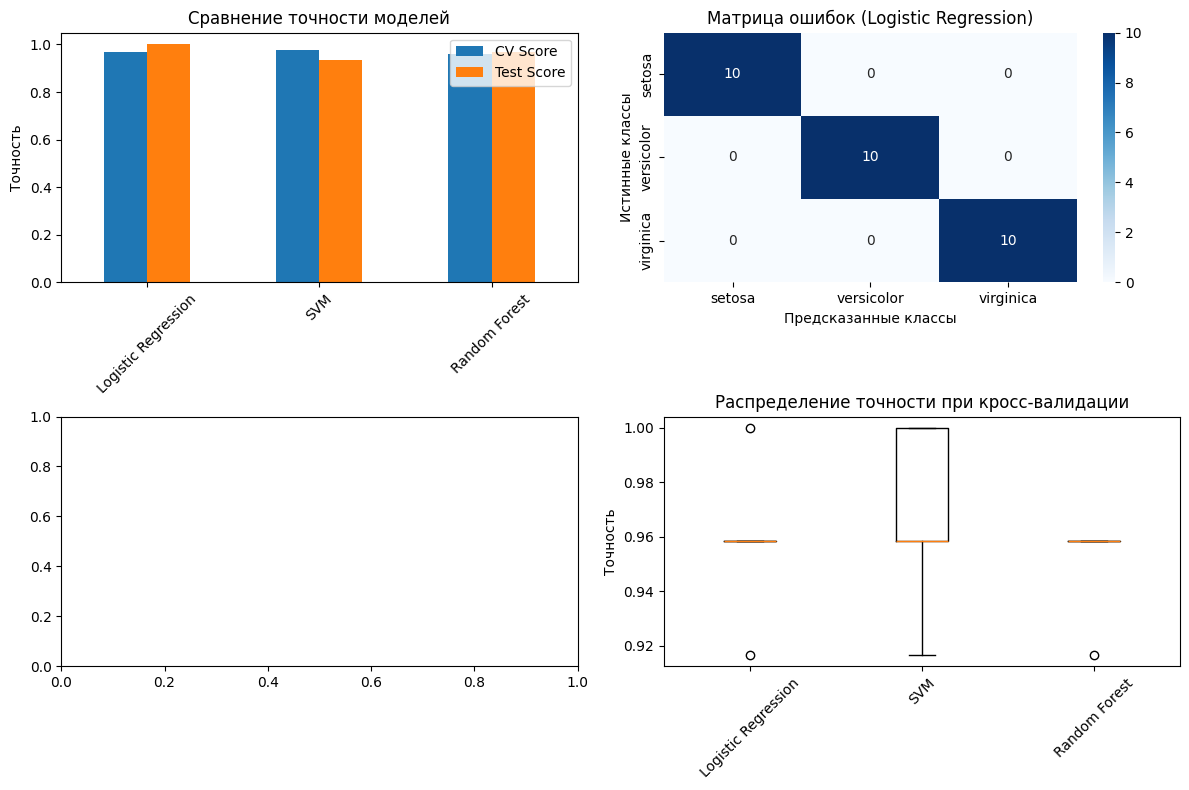

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
comparison[['CV Score', 'Test Score']].plot(kind='bar', ax=plt.gca())
plt.title('Сравнение точности моделей')
plt.ylabel('Точность')
plt.xticks(rotation=45)

best_model_name = max(test_results, key=test_results.get)
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Матрица ошибок ({best_model_name})')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')

plt.subplot(2, 2, 3)

if hasattr(best_model.named_steps['model'], 'feature_importances_'):
  importances = best_model.named_steps['model'].feature_importances_
  feature_imp = pd.DataFrame({'feature': feature_names,'importance': importances}).sort_values('importance', ascending=True)

  plt.barh(feature_imp['feature'], feature_imp['importance'])
  plt.title('Важность признаков (Random Forest)')
  plt.xlabel('Важность')

plt.subplot(2, 2, 4)
plt.boxplot([cv_scores[name] for name in models.keys()], labels=models.keys())
plt.title('Распределение точности при кросс-валидации')
plt.ylabel('Точность')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Выводы

In [22]:
print("\n1. Сравнение моделей:")
best_test_model = max(test_results, key=test_results.get)
print(f"Лучшая модель на тестовых данных: {best_test_model} "
      f"(точность: {test_results[best_test_model]:.4f})")

best_cv_model = max(best_scores, key=best_scores.get)
print(f"Лучшая модель по кросс-валидации: {best_cv_model} "
      f"(точность: {best_scores[best_cv_model]:.4f})")

print("\n2. Стабильность моделей:")
for name, scores in cv_scores.items():
    print(f"{name}: std = {scores.std():.4f}")


1. Сравнение моделей:
Лучшая модель на тестовых данных: Logistic Regression (точность: 1.0000)
Лучшая модель по кросс-валидации: SVM (точность: 0.9750)

2. Стабильность моделей:
Logistic Regression: std = 0.0264
SVM: std = 0.0312
Random Forest: std = 0.0167




1.   **Все модели показали высокую точность (>90%), что говорит о том, что датасет Iris хорошо разделяется по классам**.

2.   **Для практического применения можно выбрать**:

      *   Logistic Regression: быстрая и интерпретируемая
      *   Random Forest: высокая точность и важность признаков
      *   SVM: хорошая обобщающая способность

3.   **Рекомендации**:

      *   Для этого датасета даже простые модели работают отлично
      *   Разделение ирисов по размерам чашелистиков/лепестков четкое
      *   В реальных задачах важно учитывать интерпретируемость модели
